<a href="https://colab.research.google.com/github/swguo/DRL-HW5/blob/stage-2_create_environment/DRL_Freeway(HW5)_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb
!pip install -q gym==0.24 
!pip install -q gym[atari]
!pip install -q autorom[accept-rom-license]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    xvfb \
    libosmesa6-dev \
    software-properties-common \
    patchelf

!pip install \
    free-mujoco-py \
    gym[box2d] \
    optuna \
    pytorch-lightning \
    pyvirtualdisplay \
    PyOpenGL \
    PyOpenGL-accelerate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
patchelf is already the newest version (0.9-1).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#list of environments of gym
from gym import envs
envids = [spec.id for spec in envs.registry.all()]
for envid in sorted(envids):
    print(envid)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:424: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  f"Custom namespace `{spec.namespace}` is being overridden "


ALE/Adventure-ram-v5
ALE/Adventure-v5
ALE/AirRaid-ram-v5
ALE/AirRaid-v5
ALE/Alien-ram-v5
ALE/Alien-v5
ALE/Amidar-ram-v5
ALE/Amidar-v5
ALE/Assault-ram-v5
ALE/Assault-v5
ALE/Asterix-ram-v5
ALE/Asterix-v5
ALE/Asteroids-ram-v5
ALE/Asteroids-v5
ALE/Atlantis-ram-v5
ALE/Atlantis-v5
ALE/Atlantis2-ram-v5
ALE/Atlantis2-v5
ALE/Backgammon-ram-v5
ALE/Backgammon-v5
ALE/BankHeist-ram-v5
ALE/BankHeist-v5
ALE/BasicMath-ram-v5
ALE/BasicMath-v5
ALE/BattleZone-ram-v5
ALE/BattleZone-v5
ALE/BeamRider-ram-v5
ALE/BeamRider-v5
ALE/Berzerk-ram-v5
ALE/Berzerk-v5
ALE/Blackjack-ram-v5
ALE/Blackjack-v5
ALE/Bowling-ram-v5
ALE/Bowling-v5
ALE/Boxing-ram-v5
ALE/Boxing-v5
ALE/Breakout-ram-v5
ALE/Breakout-v5
ALE/Carnival-ram-v5
ALE/Carnival-v5
ALE/Casino-ram-v5
ALE/Casino-v5
ALE/Centipede-ram-v5
ALE/Centipede-v5
ALE/ChopperCommand-ram-v5
ALE/ChopperCommand-v5
ALE/CrazyClimber-ram-v5
ALE/CrazyClimber-v5
ALE/Crossbow-ram-v5
ALE/Crossbow-v5
ALE/Darkchambers-ram-v5
ALE/Darkchambers-v5
ALE/Defender-ram-v5
ALE/Defender-v5
ALE/

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:389: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  "The `registry.all` method is deprecated. Please use `registry.values` instead."


## Setup virtual display

In [4]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [5]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

## Import the necessary code libraries

In [6]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from pytorch_lightning.callbacks import EarlyStopping




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


## 2.5 Create the environment

In [7]:
env_name = "ALE/Freeway-v5"

In [8]:
def create_environment(name):
  env=gym.make(name)
  env=TimeLimit(env, max_episode_steps=400)
  record_interval=50
  env=RecordVideo(env, video_folder='./videos',episode_trigger=lambda x: x% record_interval==0)
  env=RecordEpisodeStatistics(env)
  return env

action_space_n= 3
(210, 160, 3)


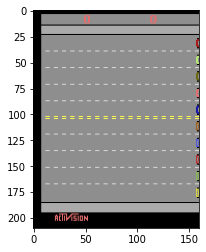

In [9]:
env = create_environment(env_name)
env.reset()
#testing
env.observation_space.sample()
env.action_space.sample()
print("action_space_n=",env.action_space.n)
print(env.render(mode='rgb_array').shape)

import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))

In [10]:
env.observation_space.shape

(210, 160, 3)

In [13]:
env.action_space.n

3